In [163]:
import csv
import pandas as pd
import math
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [51]:
df = pd.read_csv('data/original_data.csv')    

### Extract latitude + longitude data from hometown

In [52]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="cynthia-app")

# df['latitude'] = df.apply(lambda row: geolocator.geocode(row['hometown']).latitude, axis = 1)
# df['longitude'] = df.apply(lambda row: geolocator.geocode(row['hometown']).longitude, axis = 1)

In [65]:
latitude = []
for i in range(len(df)):
    h = df.iloc[i]['hometown']
    latitude.append(geolocator.geocode(h).latitude)

In [60]:
longitude = []
for i in range(len(df)):
    h = df.iloc[i]['hometown']
    longitude.append(geolocator.geocode(h).longitude)

In [297]:
coordinates = []
for i in range(len(df)):
    coordinates.append([latitude[i], longitude[i]])
coordinates = np.array(coordinates)

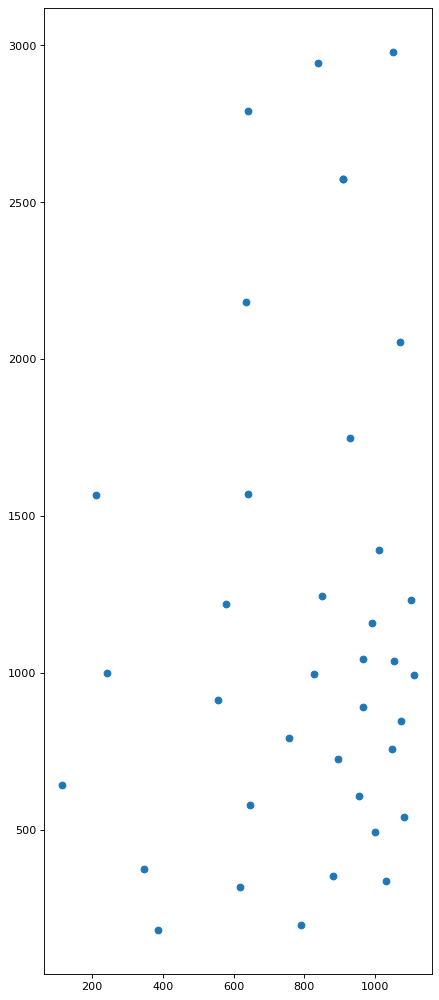

In [498]:
from lloyd import Field

field = Field(coordinates)
for i in range(5): #18, 5
    field.relax()
    
transformed = field.get_points()
x = transformed[:, 0]
transformed[:, 0] = (x - min(x))/(max(x) - min(x))*995 + 115
y = field.get_points()[:, 1]
transformed[:, 1] = (y - min(y))/(max(y) - min(y))*2800 + 180

figure(figsize=(12.5/2, 16), dpi=80)
plt.scatter(transformed[:, 0], transformed[:, 1])

In [499]:
df['latitude'] = transformed[:, 0]
df['longitude'] = transformed[:, 1]

### ID data

In [500]:
# create id dict
info_by_name = {}

for i in range(len(df)):
    info_by_name[df.iloc[i]['name'].strip(' ')] = {'id': i}
    
respondent_names = list(info_by_name.keys())
num_respondents = len(respondent_names)

In [501]:
for i in range(len(df)):
    s = df.iloc[i]['roommates']
    if type(s) != str: continue
    s = s.replace('\n', ', ')
    split_list = s.split(', ')
    roommates_list = []
    for s in split_list:
        cleaned_name = s.strip(',').strip(' ')
        if cleaned_name not in info_by_name:
            info_by_name[cleaned_name] = {'id': len(info_by_name), 'connections': set()}
        roommates_list.append(cleaned_name)
        
    s = df.iloc[i]['people']
    if type(s) != str: continue
    s = s.replace('\n', ', ')
    split_list = s.split(', ')
    people_list = []
    for s in split_list:
        cleaned_name = s.strip(',').strip(' ')
        if cleaned_name not in info_by_name:
            info_by_name[cleaned_name] = {'id': len(info_by_name), 'connections': set()}
        people_list.append(cleaned_name)

### Connections

In [502]:
roommates_respondents = []
friendships_respondents = []
roommates_other = []
friendships_other = []

connects_per_indiv = []

for i in range(len(df)):
    respondent_name = df.iloc[i]['name']
    respondent_id = i
    curr_num_connect = 0
    
    s = df.iloc[i]['roommates']
    if type(s) == str:
        s = s.replace('\n', ', ')
        split_list = s.split(', ')

        curr_num_connect += len(split_list)
        for s in split_list:
            roommate_name = s.strip(',').strip(' ')
            roommate_id = info_by_name[roommate_name]['id']
            if roommate_id < num_respondents:
                roommates_respondents.append([min(respondent_id, roommate_id), max(respondent_id, roommate_id)])
            else:
                roommates_other.append([respondent_id, roommate_id])
                info_by_name[roommate_name]['connections'].add(respondent_id)
            
    s = df.iloc[i]['people']
    if type(s) == str:
        s = s.replace('\n', ', ')
        split_list = s.split(', ')

        curr_num_connect += len(split_list)
        for s in split_list:
            friend_name = s.strip(',').strip(' ')
            friend_id = info_by_name[friend_name]['id']
            if friend_id < num_respondents:
                friendships_respondents.append([min(respondent_id, friend_id), max(respondent_id, friend_id)])
            else:
                friendships_other.append([respondent_id, friend_id])
                info_by_name[friend_name]['connections'].add(respondent_id)
                
    connects_per_indiv.append(curr_num_connect)

In [503]:
roommates_respondents = list(list(i) for i in set(tuple(i) for i in roommates_respondents))
friendships_respondents = list(list(i) for i in set(tuple(i) for i in friendships_respondents))

num_connections = sum([len(roommates_respondents), len(friendships_respondents), 
                       len(roommates_other), len(friendships_other)])
print(num_connections, 'connections visualized!!')

665 connections visualized!!


## Compile Respondent Data

#### Concentration Encoding

In [512]:
conc_to_id.keys()

dict_keys(['Government', 'Economics', 'Computer Science', 'Statistics', 'Psychology', 'Biomedical Engineering', 'Molecular and Cellular Biology', 'Applied Mathematics', 'Women, Gender, and Sexuality Studies', 'Mechanical Engineering', 'Physics', 'Philosophy', 'History and Literature', 'Sociology', 'Integrative Biology', 'Music', 'History', 'English', 'Art Film and Visual Studies', 'Mathematics', 'Global Health and Health Policy', 'Social Studies', 'Energy and Environment', 'Neuroscience'])

In [504]:
conc_to_id = {}
for curr in df['concentration']:
    if 'Secondary' in curr:
        curr = curr.replace(', Secondary in ', ' + ')
    curr_list = curr.split(' + ')
    for c in curr_list:
        if c[-1] == " ":
            c = c[:-1]
        if c not in conc_to_id:
            conc_to_id[c] = len(conc_to_id)

#### State/Country Encoding

In [505]:
state_to_id = {'International': 0}
for curr in df['hometown']:
    s = curr.split(', ')
    if len(s) == 3:
        state = s[1]
        if state not in state_to_id:
            state_to_id[state] = len(state_to_id)

In [506]:
data = []
for i in range(num_respondents):
    row = df.iloc[i]
    
    # get state or country 
    where_from = ''
    s = row['hometown'].split(', ')
    if len(s) == 3:
        where_from = state_to_id[s[1]]
    else:
        where_from = '0'
        
    # get concentration encoding
    conc_code = []
    conc = row['concentration']
    secondary_code = -1
    if 'Secondary' in conc:
        conc_secondary_split = conc.split(', Secondary in ')
        secondary = conc_secondary_split[-1]
        if secondary[-1] == " ": secondary = secondary[:-1]
        secondary_code = conc_to_id[secondary]
        conc = conc_secondary_split[0]
    conc_list = conc.split(' + ')
    for c in conc_list:
        if c[-1] == " ": c = c[:-1]
        conc_code.append(conc_to_id[c])
    
    x = row['latitude']
    y = row['longitude']
    person_info = [i, row['name'], x, y, where_from, row['class'], conc_code, secondary_code]
    
    data.append(person_info)
    
respondent_data = pd.DataFrame(data, columns=['id', 'name', 'x', 'y', 'from', 
                                              'class', 'concentration', 'secondary'])
respondent_data['num_connections'] = connects_per_indiv

## Compile data for non-respondents

In [507]:
data = []

for name in info_by_name:
    if name in respondent_names:
        continue
    row = info_by_name[name]
    curr_data = [row['id'], name]
    
    # Compute placement in visualization
    # If number connections > 1, take average location of connections to get location
    # Otherwise random around a circle of single connection
    conns = list(row['connections'])
    num_connections = len(conns)
    x = 0
    y = 0
    if num_connections > 1:
        sum_x = 0
        sum_y = 0
        for c in conns:
            sum_x += respondent_data.iloc[c]['x']
            sum_y += respondent_data.iloc[c]['y']
        x = sum_x / num_connections
        y = sum_y / num_connections
        # can add randomness factor here
    else:
        single_conn = conns[0]
        theta = random.randrange(0, 360)
        num_conns = respondent_data.iloc[single_conn]['num_connections']
        r = random.randrange(max(60, num_conns), max(150, num_conns*3))
        x = respondent_data.iloc[single_conn]['x'] + r*math.cos(theta)
        y = respondent_data.iloc[single_conn]['y'] + r*math.sin(theta)
        
    curr_data.append(x)
    curr_data.append(y)
    curr_data.append(len(row['connections']))

    data.append(curr_data)

other_data = pd.DataFrame(data, columns=['id', 'name', 'x', 'y', 'num_connections'])

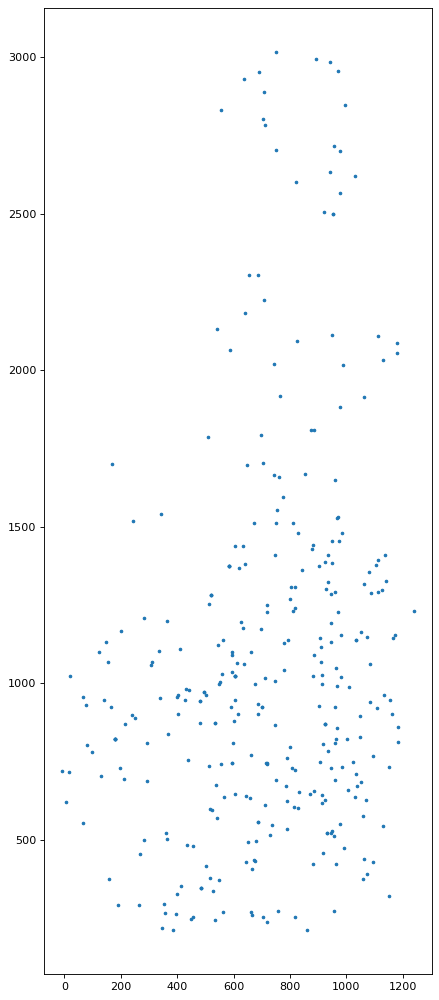

In [508]:
figure(figsize=(12.5/2, 16), dpi=80)
plt.scatter(other_data['x'], other_data['y'], s = 5)

## Export data for visualization in p5.js

In [509]:
# Individual data
other_data.to_csv('data/other_data.csv', index = False)
respondent_data.to_csv('data/respondent_data.csv', index = False)

In [510]:
# Connections data
with open("data/roommates_respondents.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(roommates_respondents)
    
with open("data/friendships_respondents.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(friendships_respondents)
    
with open("data/roommates_other.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(roommates_other)
    
with open("data/friendships_other.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(friendships_other)